<a href="https://colab.research.google.com/github/monta0315/pytorch_pra/blob/main/Datasets%26Dataloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

データセットの関するコードは訓練パートと切り離すべき

pytorchにはデータセットを扱う基本要素が2つある
torch.utils.data.DataLoaderとtorch.utils.data.Dataset

Datasetにはサンプルとそれに対応するラベルが格納され、DataLoaderにはイテレート処理可能なデータが格納される(繰り返し処理的な)

DataLoaderはサンプルを簡単に利用できるようにDatasetをイテレート処理可能なものにラップする

Pytorchは多くのデータセットを提供していてそれはtorch.utils.data.Datasetを継承している

TorchVisionからFashionMnistをロードする

FashionMnistは60000個の訓練データと10000個のテストデータから構成された記事画像のデータセット

各サンプルは28x28のグレースケール画像と10クラスのうちの1つのラベルから構成されている

Datasetを読み込む際には以下のパラメータを使用する

- root :データが格納されているパスを指定
- train : 訓練データorテストデータを指定
- download = true : rootにデータが存在しない場合はインターネットからパクってくる
- transformとtarget_transform: 特徴量とラベルの変換を指定

In [1]:
%matplotlib inline

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor,Lambda
import matplotlib.pyplot as plt

In [3]:
train_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train = False,
    download = True,
    transform = ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


#データセットの反復処理と可視化
Datasetの特定のindexを指定する際にはリスト操作と同様にtrain_data[index]と記載する

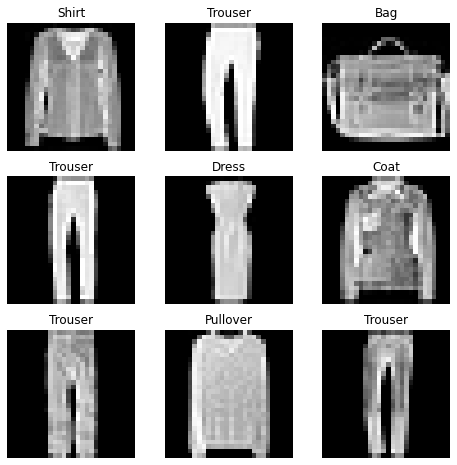

In [13]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8,8))
cols,rows = 3,3
for i in range(1,cols*rows +1):
    sample_index = torch.randint(len(train_data),size=(1,)).item()
    img,label = train_data[sample_index]
    figure.add_subplot(row,cols,i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(),cmap="gray")
plt.show()

#カスタムデータセットの作成

自分でカスタムしたDatasetを作るためには,__init__,__len__,__getitem__の3つの関数は必ず実装する必要がある


In [16]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self,annotations_file,img_dir,transform=None,target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir,self.img_labels.iloc[idx,0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx,1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        sample = {"image":image,"label":label}
        return sample

#init
__init__関数はDatasetオブジェクトがインスタンス化される際に一度だけ実行される
画像、アノテーションファイル、それらに対する変換処理の初期設定を行う

#len
__len__関数はデータセットのサンプル数を返す関数

#getitem
__getitem__関数は指定されたidxに対応するサンプルをデータセットから読み込んで返す関数
indexに基づいて画像ファイルのパスを特定し、read_image関数で画像ファイルをテンソルに変換する
加えてself.img_lablesから対応するラベルを抜き出す
そしてtransformを必要に応じてimage,labelに適用し最後にpythonのオブジェクト型変数として画像とラベルを変換する

#DataLoaderの使用方法

Datasetを使用することで1つのサンプルのデータとラベルを取り出すことができる

しかし、モデルの訓練時にはミニバッチ単位でデータを取り扱いたく、また各epochでデータはシャッフルされていて欲しい(訓練データの過学習を防ぐため）

加えてPythonのmultiprocessingを使用し、複数データの取り出しを高速化したい

DataLoaderは上記で示した処理を実行できるようにしているAPI

In [17]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data,batch_size=64,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=64,shuffle=True)

#DataLoaderを用いた繰り返し処理
データセットをDataLoaderに読み込ませ、必要に応じてデータセットを反復処理させることができる
以下の反復処理ではtrain_featuresとtrain_lablesのミニバッチを返す


torch.Size([64, 1, 28, 28])
torch.Size([64])


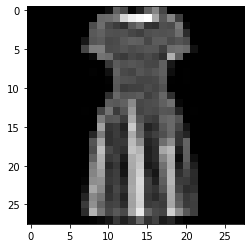

tensor(3)


In [21]:
#Display image and label
#iter()とnextは擬似的なfor文？
train_features,train_labels = next(iter(train_dataloader))
print(train_features.size())
print(train_labels.size())
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img,cmap="gray")
plt.show()
print(label)

